# Exercise 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set a seed for reproducibility (optional, but good for debugging)
np.random.seed(42)
# 1. Construct any non-square matrix A (m x n)
m = 10
n = 6

A = np.random.randn(m, n)

print(f"Matrix A created with shape: {A.shape}")
print("Matrix A:")
print(np.round(A, 2)) # Printing rounded values for cleaner output



Matrix A created with shape: (10, 6)
Matrix A:
[[ 0.5  -0.14  0.65  1.52 -0.23 -0.23]
 [ 1.58  0.77 -0.47  0.54 -0.46 -0.47]
 [ 0.24 -1.91 -1.72 -0.56 -1.01  0.31]
 [-0.91 -1.41  1.47 -0.23  0.07 -1.42]
 [-0.54  0.11 -1.15  0.38 -0.6  -0.29]
 [-0.6   1.85 -0.01 -1.06  0.82 -1.22]
 [ 0.21 -1.96 -1.33  0.2   0.74  0.17]
 [-0.12 -0.3  -1.48 -0.72 -0.46  1.06]
 [ 0.34 -1.76  0.32 -0.39 -0.68  0.61]
 [ 1.03  0.93 -0.84 -0.31  0.33  0.98]]


In [3]:
# 2. Compute its SVD
# np.linalg.svd returns:
# U: The left singular vectors (orthogonal matrix, m x m)
# s: The singular values (1D vector), NOT the full diagonal matrix!
# Vt: The right singular vectors transposed (orthogonal matrix, n x n)
U, s, Vt = np.linalg.svd(A, full_matrices=True)

# Print shapes to understand the output [cite: 79]
print(f"Shape of U: {U.shape}")
print(f"Shape of singular values vector s: {s.shape}")
print(f"Shape of Vt: {Vt.shape}")

# To perform matrix multiplication A = U * Sigma * Vt, we must construct the full Sigma matrix.
# Sigma must have the same dimensions as A (m x n) to make the matrix multiplication valid.
# Source [cite: 80-82]: Implementation of constructing full Sigma matrix
Sigma = np.zeros((m, n))

# Fill the diagonal of the top n x n block with the singular values
# We use min(m, n) to handle cases where m < n or m > n, though here m > n.
k = min(m, n)
Sigma[:k, :k] = np.diag(s)

print(f"\nConstructed full Sigma matrix with shape: {Sigma.shape}")

Shape of U: (10, 10)
Shape of singular values vector s: (6,)
Shape of Vt: (6, 6)

Constructed full Sigma matrix with shape: (10, 6)


In [4]:
# 3. Verify numerically that A ≈ U * Sigma * Vt

# Perform the matrix multiplication: U @ Sigma @ Vt
# The @ symbol is the operator for matrix multiplication in Python
A_reconstructed = U @ Sigma @ Vt

# Calculate the difference matrix
difference = A - A_reconstructed

# Calculate the Frobenius norm of the difference (Euclidean norm of the flattened matrix)
# Source[cite: 52]: The concept of minimizing norm distance
frobenius_error = np.linalg.norm(difference, ord='fro')

# Check if the matrices are close within a small tolerance (floating point precision)
is_close = np.allclose(A, A_reconstructed)

print(f"Reconstruction Error (Frobenius Norm): {frobenius_error}")
print(f"Is the reconstruction effectively zero? {np.isclose(frobenius_error, 0)}")
print(f"Does np.allclose agree? {is_close}")


Reconstruction Error (Frobenius Norm): 7.713268229125658e-15
Is the reconstruction effectively zero? True
Does np.allclose agree? True


Singular Values (sigma): [4.53270928 3.73907164 2.72173241 1.89806806 1.59069575 1.43784506]


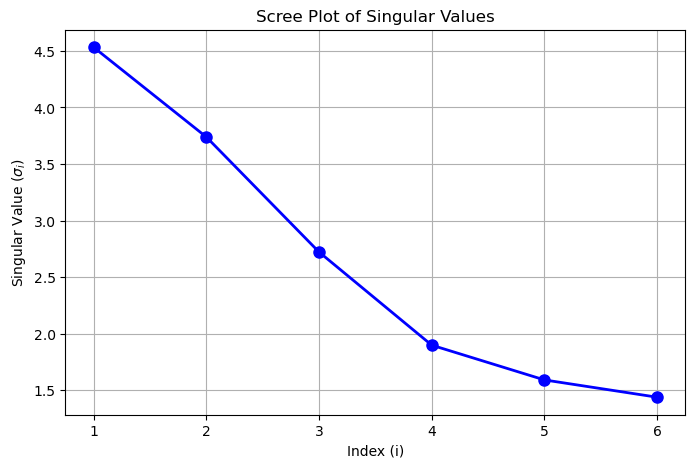

In [5]:
# 4. Print and plot the singular values
print("Singular Values (sigma):", s)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(s) + 1), s, 'bo-', linewidth=2, markersize=8)
plt.title('Scree Plot of Singular Values')
plt.xlabel('Index (i)')
plt.ylabel('Singular Value ($\sigma_i$)')
plt.grid(True)
plt.xticks(range(1, len(s) + 1))
plt.show()

### **Comments and Analysis**


1. Why do singular values appear in descending order?

By definition of the SVD, the singular values are always ordered such that $\sigma_1 \ge \sigma_2 \ge \dots \ge 0$2.

- **Mathematical Reason:** The SVD algorithm iteratively finds the direction (singular vector) capturing the *maximum* possible variance in the data. $\sigma_1$ corresponds to the direction of greatest variance. $\sigma_2$ corresponds to the direction of the next highest variance that is orthogonal to the first, and so on.
- **Practical Consequence:** This ordering allows us to identify the "rank" of the matrix easily

2. Why do small singular values correspond to "less important" directions?

The SVD decomposes a matrix into a sum of rank-1 matrices (dyads):$$A = \sum sigma_i u_i v_i^T$$

- The singular value $\sigma_i$ acts as a weight or scaling factor for the $i$-th dyad

- If $\sigma_i$ is very small, the term $\sigma_i u_i v_i^T$ contributes almost nothing to the total sum that makes up $A$.
- Therefore, these directions usually represent noise or redundancy. Discarding them (Truncated SVD) allows for compression with minimal information loss
3. Why does floating-point arithmetic make exact zeros rare?

In pure mathematics, the rank of a matrix is the number of non-zero singular values. However, computers use finite precision (floating-point arithmetic).

- **Numerical Noise:** Operations on real numbers introduce tiny rounding errors. Even if a singular value should theoretically be 0 (indicating dependent columns), the computer might calculate it as $1.2 \times 10^{-16}$.
- **Numerical Rank:** Because of this, we look for "numerical rank"—the number of singular values significantly larger than zero (above a tolerance threshold)


# Exercise 2

In [7]:
def rank_k_approx(A, k):
    """
    Computes the best rank-k approximation of matrix A.
    
    Parameters:
    A (numpy.ndarray): Input matrix.
    k (int): The target rank (number of singular values to keep).
    
    Returns:
    A_k (numpy.ndarray): The approximation matrix of rank k.
    """
    
    # 1. Compute the SVD of A
    # full_matrices=False is standard for SVD applications like this; 
    # it returns compact shapes: U is (m, min(m,n)), Vt is (min(m,n), n)
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    
    # Safety check: Ensure k isn't larger than the number of available singular values
    if k > len(s):
        k = len(s)
    
    # 2. Construct the rank-k matrices
    # Slice U to keep the first k columns -> shape (m, k)
    U_k = U[:, :k]
    
    # Slice s to keep the first k values and create a diagonal matrix -> shape (k, k)
    S_k = np.diag(s[:k])
    
    # Slice Vt to keep the first k rows -> shape (k, n)
    Vt_k = Vt[:k, :]
    
    # 3. Compute A_k via matrix multiplication
    # A_k = U_k * S_k * Vt_k
    A_k = U_k @ S_k @ Vt_k
    
    return A_k


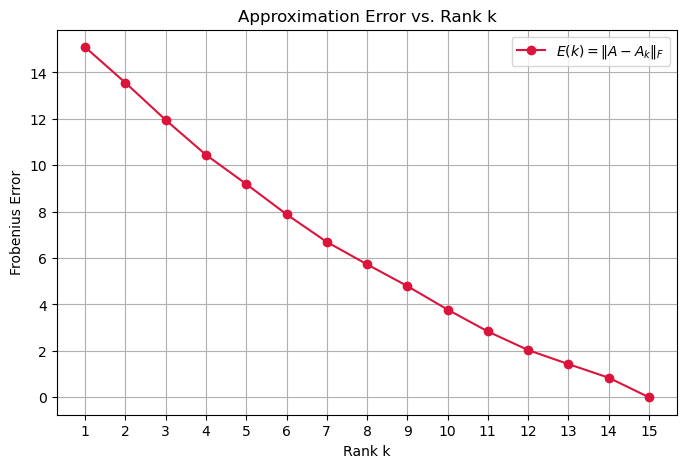

In [8]:
# 1. Create a random matrix to test
# We use a 20x15 matrix to see clear steps in the plot
m, n = 20, 15
np.random.seed(42) # For reproducibility
A = np.random.randn(m, n)

# The maximum rank is limited by the smaller dimension
max_rank = min(m, n)

# 2. Loop through all possible values of k
k_values = range(1, max_rank + 1)
errors = []

for k in k_values:
    # Compute approximation
    A_k = rank_k_approx(A, k)
    
    # Compute error: Frobenius norm of the difference matrix
    # Source[cite: 52]: Minimizing the 2-norm (Frobenius) distance
    difference = A - A_k
    error = np.linalg.norm(difference, ord='fro')
    
    errors.append(error)

# 3. Plot E(k) vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, 'o-', color='crimson', label=r'$E(k) = \|A - A_k\|_F$')

plt.title('Approximation Error vs. Rank k')
plt.xlabel('Rank k')
plt.ylabel('Frobenius Error')
plt.xticks(k_values) # Force integer ticks on x-axis
plt.grid(True)
plt.legend()
plt.show()

**Why does SVD give the optimal rank-$k$ approximation?**

The optimality is guaranteed by the **Eckart-Young-Mirsky Theorem**.

1. **Minimizing Distance:** The theorem states that if we want to find a matrix $B$ of rank $k$ that minimizes the distance to $A$ (specifically, the Frobenius norm $\|A - B\|\_F$), that optimal matrix is exactly the truncated SVD matrix $A\_k$


2. Descending Order Importance: The SVD decomposes the matrix into a sum of "dyads" ($u\_i v\_i^T$) weighted by their singular values $\sigma\_i$. The error when we stop at rank $k$ is determined by the singular values we leave out:

$$\| A - A\_k \|\_F^2 = \sum\_{j=k+1}^{\min(m,n)} \sigma_j^2$$

Because the SVD algorithm guarantees that singular values are sorted in descending order ($\sigma\_1 \ge \sigma\_2 \ge \dots \ge 0$), discarding the tail ($\sigma\_{k+1}, \dots$) ensures we are always discarding the *smallest possible* amount of information (variance), thereby minimizing the error

# Exercise 3

<class 'numpy.ndarray'>
Image loaded. Shape: 512x512


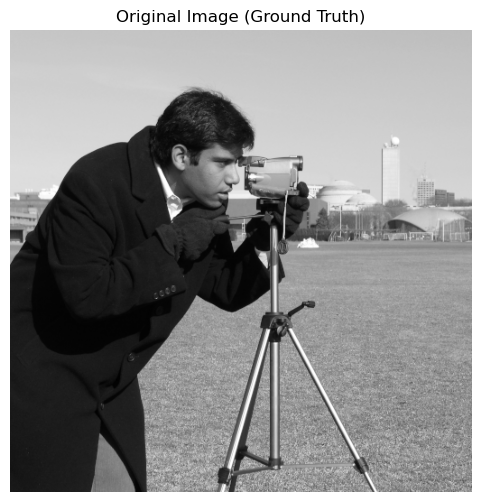

In [10]:
import skimage.data

X = skimage.data.camera()
print(type(X))
# Verify the shape is 512x512 as expected
m, n = X.shape
print(f"Image loaded. Shape: {m}x{n}")

# Visualize the original image
plt.figure(figsize=(6, 6))
plt.imshow(X, cmap='gray')
plt.title("Original Image (Ground Truth)")
plt.axis('off')
plt.show()

In [11]:
# 2. Compute its SVD: X = U * Sigma * Vt
# We convert to float for precision during SVD (images are usually uint8)
X_float = X.astype(float)

# Compute SVD
# Source[cite: 78]: using np.linalg.svd
U, s, Vt = np.linalg.svd(X_float, full_matrices=False)

print(f"SVD Computed.")
print(f"U shape: {U.shape}, s shape: {s.shape}, Vt shape: {Vt.shape}")

SVD Computed.
U shape: (512, 512), s shape: (512,), Vt shape: (512, 512)


In [12]:
# 3. For k in {5, 20, 50, 100, 200}...
k_values = [5, 20, 50, 100, 200]

# Storage for results to plot later
reconstructed_images = []
compression_factors = []
reconstruction_errors = []

print(f"{'k':<5} | {'Compression':<12} | {'Error (Frobenius)':<20}")
print("-" * 45)

for k in k_values:
    # --- A. Compute rank-k approximation X_k ---
    # Slice the matrices to keep top k components
    # Source[cite: 132]: formula for k-rank approximation
    U_k = U[:, :k]
    S_k = np.diag(s[:k])
    Vt_k = Vt[:k, :]
    
    # Reconstruct: X_k = U_k @ S_k @ Vt_k
    X_k = U_k @ S_k @ Vt_k
    reconstructed_images.append(X_k)
    
    # --- B. Compute Compression Factor c_k ---
    # Source: Compression factor formula
    # Size of original: m * n
    # Size of compressed: k * (m + n + 1) -> (vectors u, vectors v, scalars s)
    original_size = m * n
    compressed_size = k * (m + n + 1)
    
    c_k = 1 - (compressed_size / original_size)
    compression_factors.append(c_k)
    
    # --- C. Compute Reconstruction Error ---
    # Frobenius norm of the difference
    error = np.linalg.norm(X_float - X_k, ord='fro')
    reconstruction_errors.append(error)
    
    print(f"{k:<5} | {c_k:.4f}       | {error:.4f}")

k     | Compression  | Error (Frobenius)   
---------------------------------------------
5     | 0.9804       | 13086.8683
20    | 0.9218       | 7699.9091
50    | 0.8045       | 4836.0689
100   | 0.6090       | 2992.1444
200   | 0.2180       | 1342.3582


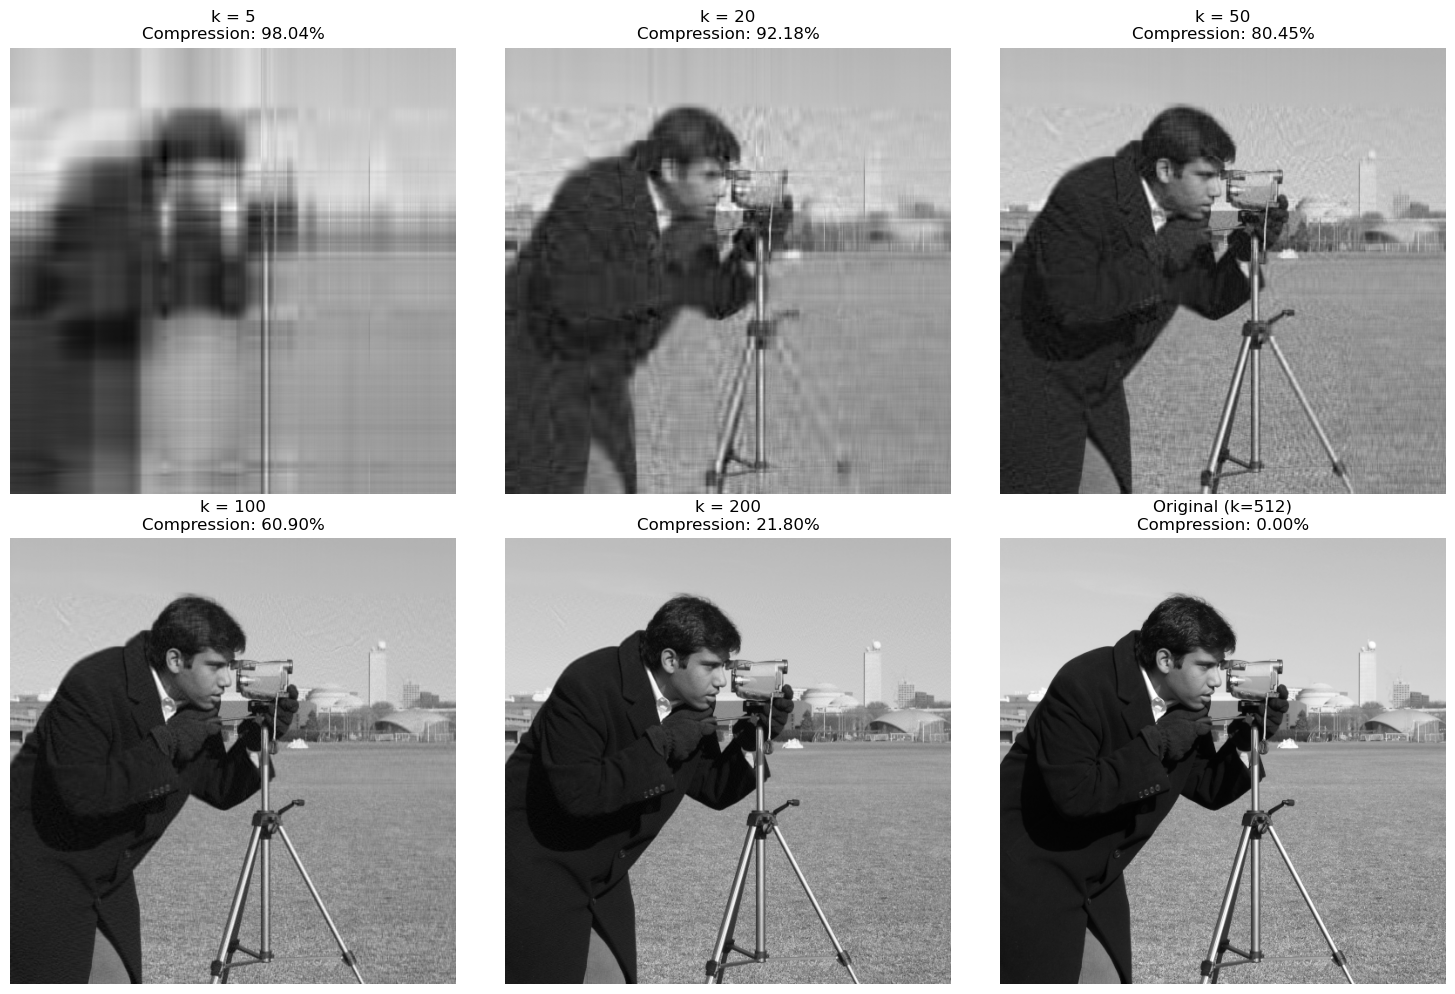

In [13]:
# Plot each reconstructed image
# We'll create a 2x3 grid to show 5 approximations + 1 original
plt.figure(figsize=(15, 10))

# Plot the 5 reconstructions
for i, k in enumerate(k_values):
    plt.subplot(2, 3, i + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title(f"k = {k}\nCompression: {compression_factors[i]:.2%}")
    plt.axis('off')

# Plot original for comparison
plt.subplot(2, 3, 6)
plt.imshow(X, cmap='gray')
plt.title(f"Original (k={min(m,n)})\nCompression: 0.00%")
plt.axis('off')

plt.tight_layout()
plt.show()

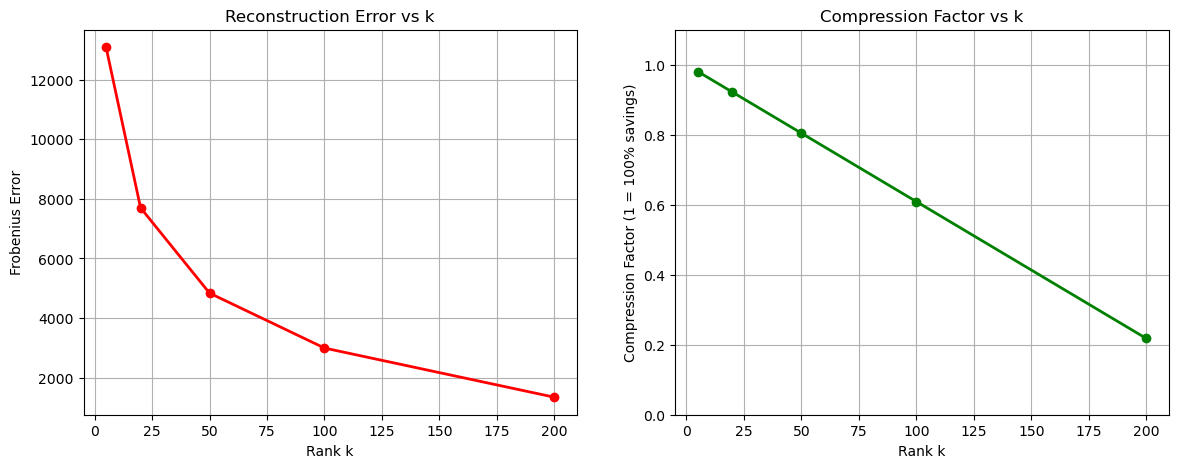

In [14]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Reconstruction Error vs k
ax1.plot(k_values, reconstruction_errors, 'r-o', linewidth=2)
ax1.set_title("Reconstruction Error vs k")
ax1.set_xlabel("Rank k")
ax1.set_ylabel("Frobenius Error")
ax1.grid(True)

# Plot 2: Compression Factor vs k
ax2.plot(k_values, compression_factors, 'g-o', linewidth=2)
ax2.set_title("Compression Factor vs k")
ax2.set_xlabel("Rank k")
ax2.set_ylabel("Compression Factor (1 = 100% savings)")
ax2.grid(True)
ax2.set_ylim(0, 1.1) # Keep y-axis between 0 and 1

plt.show()


### **Comments and Analysis**

*This section answers the qualitative questions in point 4 of the exercise.*

**1. How visual quality improves with $k$:**

- At **$k=5$**, the image is very blurry; we can distinguish the silhouette of the cameraman against the background, but no details.
- At **$k=50$**, the image is quite sharp. The main features (tripod, coat texture, background buildings) are visible.
- At **$k=200$**, the image is visually indistinguishable from the original to the human eye, even though we are using less than half the data.

**2. Why most of the "energy" is contained in the first singular values:**

- Real-world data (like images) contains high correlations. Adjacent pixels often have similar colors (the sky is mostly uniform, the grass is textured but consistent).
- The SVD sorts singular values $\sigma_i$ by magnitude. The first few components capture these dominant, large-scale correlations (the global structure).
- Later singular values capture high-frequency details (noise, sharp edges). Since most of an image is "structure" rather than "noise," the first few $\sigma$ values are very large, while the tail drops off quickly.

**3. The trade-off between compression and fidelity:**

- This is an inverse relationship.
- **High Compression ($k=5$):** We save ~98% of space, but fidelity is poor.
- **High Fidelity ($k=200$):** The image is perfect, but we only save ~20% space.
- **Sweet Spot:** Often around $k=50$ for this image, where we achieve ~80% compression while maintaining excellent visual recognizability.

**4. The connection between SVD and optimal low-rank approximation:**

- As discussed in Exercise 2, the Eckart-Young-Mirsky theorem guarantees that for any chosen file size (determined by rank $k$), the truncated SVD provides the mathematically *best possible* reconstruction (lowest squared error). No other method can approximate the matrix $X$ better with the same number of parameters.

# Exercise 5

In [16]:
from mpl_toolkits.mplot3d import Axes3D # For the 3D plot later
import pandas as pd

df = pd.read_csv('data/train.csv')
print("Data loaded successfully.")

# Convert to numpy array
data = df.values
print(f"Data shape: {data.shape}")

# Separate features (pixels) and target (labels)
# The first column is 'label', the rest are pixels (pixel0 to pixel783)
# Note: Check your CSV structure. Usually MNIST CSVs have label in col 0.
# The slides example used code that assumed label was last, but Kaggle sets usually have label first.
# We will assume standard Kaggle format: label is column 0.
Y_all = data[:, 0]
X_all = data[:, 1:]

print(f"Features (X) shape: {X_all.shape}")
print(f"Labels (Y) shape: {Y_all.shape}")

Data loaded successfully.
Data shape: (42000, 785)
Features (X) shape: (42000, 784)
Labels (Y) shape: (42000,)


In [ ]:
def filter_digits(X, Y, digit1, digit2):
    """
    Filters the dataset to keep only samples corresponding to two specific digits.
    [cite_start]Source: Filtering digits logic [cite: 234-240]
    """
    mask = (Y == digit1) | (Y == digit2)
    X_filtered = X[mask]
    Y_filtered = Y[mask]
    return X_filtered, Y_filtered

def split_data(X, Y, train_ratio=0.8):
    """
    Splits data into training and test sets randomly.
    [cite_start]Source: Splitting the dataset [cite: 261-277]
    """
    N = X.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    train_size = int(N * train_ratio)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]
    
    X_train, Y_train = X[train_idx], Y[train_idx]
    X_test, Y_test = X[test_idx], Y[test_idx]
    
    return (X_train, Y_train), (X_test, Y_test)



Helper functions defined.


In [18]:
# --- Configuration ---
digit_a = 3
digit_b = 4

# 1. Filter for specific digits
X_filtered, Y_filtered = filter_digits(X_all, Y_all, digit_a, digit_b)
print(f"Filtered for digits {digit_a} and {digit_b}. New shape: {X_filtered.shape}")

# 2. Split into training and test
(X_train, Y_train), (X_test, Y_test) = split_data(X_filtered, Y_filtered)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 3. Center the training data
# Compute centroid of training data
# [cite_start]Source: Centering logic [cite: 165-168]
centroid = np.mean(X_train, axis=0)

# Subtract centroid from training data
Xc_train = X_train - centroid

# IMPORTANT: Subtract the SAME centroid from test data (do not recompute centroid on test!)
# This ensures test data is projected into the same coordinate system defined by training data.
Xc_test = X_test - centroid

# 4. Compute Reduced SVD
# We only need the top k=2 components, but np.linalg.svd gives all unless we use a sparse solver.
# For simplicity with standard numpy, we compute full_matrices=False.
# [cite_start]Source: SVD computation [cite: 295]
U, s, Vt = np.linalg.svd(Xc_train, full_matrices=False)

# 5. Choose k=2 principal components
k = 2
Vk = Vt[:k, :].T  # Transpose Vt to get V (shape: d x k)

# 6. Project Data
# Z = Xc * V_k
# [cite_start]Source: Projection formula [cite: 162]
Z_train = Xc_train @ Vk
Z_test = Xc_test @ Vk

print(f"Projected Z_train shape: {Z_train.shape}")

Filtered for digits 3 and 4. New shape: (8423, 784)
Training set size: 6738
Test set size: 1685
Projected Z_train shape: (6738, 2)


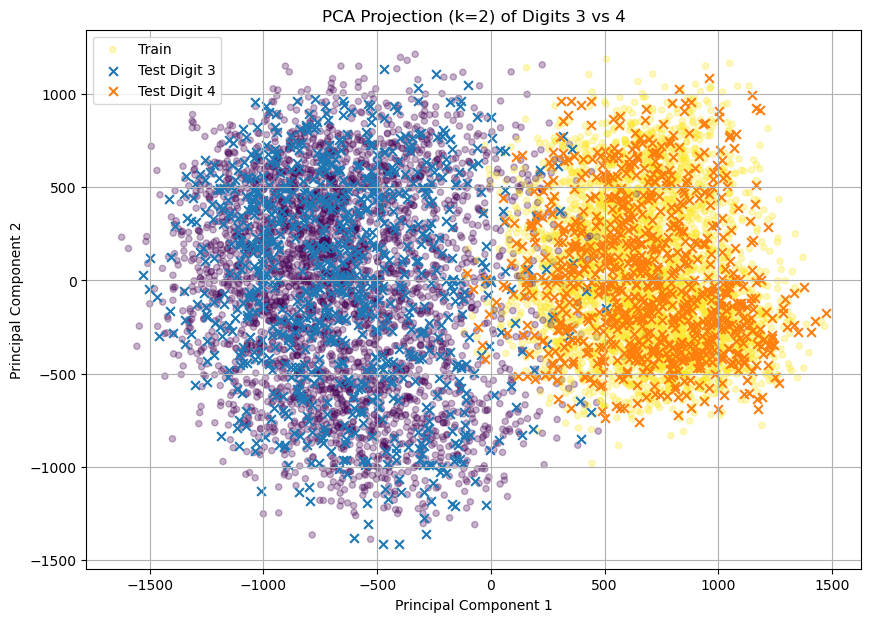

In [19]:
# 7. Plot Scatterplot
plt.figure(figsize=(10, 7))

# Plot Training Data (lighter colors or 'o' markers)
scatter_train = plt.scatter(Z_train[:, 0], Z_train[:, 1], c=Y_train, 
                            cmap='viridis', alpha=0.3, label='Train', s=20)

# Plot Test Data (darker colors or 'x' markers to distinguish)
# We map the same colors but use a different marker
for digit in [digit_a, digit_b]:
    # Select test points for this digit
    mask = (Y_test == digit)
    # Plot them
    plt.scatter(Z_test[mask, 0], Z_test[mask, 1], 
                marker='x', s=40, label=f'Test Digit {digit}')

plt.title(f"PCA Projection (k=2) of Digits {digit_a} vs {digit_b}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


--- Analyzing Digits 5 vs 8 ---


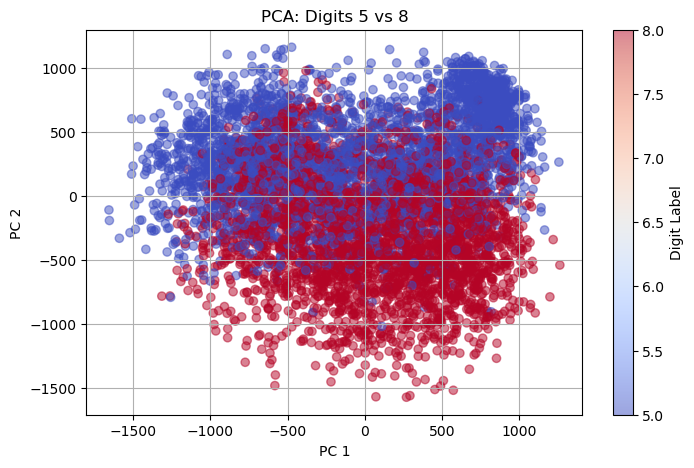


--- Analyzing Digits 1 vs 7 ---


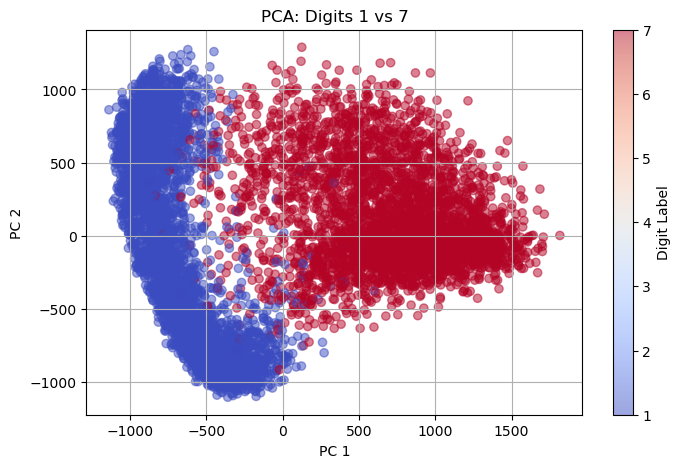

In [20]:
def analyze_digit_pair(digit1, digit2):
    print(f"\n--- Analyzing Digits {digit1} vs {digit2} ---")
    
    # Filter & Split
    X_filt, Y_filt = filter_digits(X_all, Y_all, digit1, digit2)
    (X_tr, Y_tr), (X_te, Y_te) = split_data(X_filt, Y_filt)
    
    # Center
    cent = np.mean(X_tr, axis=0)
    Xc_tr = X_tr - cent
    Xc_te = X_te - cent
    
    # SVD & Project
    U, s, Vt = np.linalg.svd(Xc_tr, full_matrices=False)
    Vk = Vt[:2, :].T
    Z_tr = Xc_tr @ Vk
    
    # Plot
    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(Z_tr[:, 0], Z_tr[:, 1], c=Y_tr, cmap='coolwarm', alpha=0.5)
    plt.title(f"PCA: Digits {digit1} vs {digit2}")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.colorbar(scatter, label='Digit Label')
    plt.grid(True)
    plt.show()

# 8. Repeat with other pairs
analyze_digit_pair(5, 8) # Often hard to separate (both are round/looping)
analyze_digit_pair(1, 7) # Often easier, but 1s and 7s can look similar

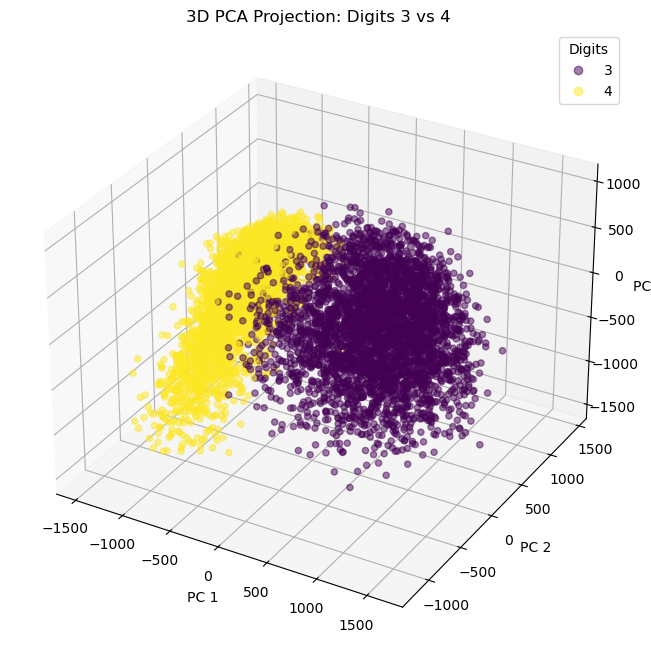

In [21]:
# 9. Try k=3 and use a 3D scatterplot
# Let's go back to the original pair (3 vs 4) or a hard one like (5 vs 8)
digit_a, digit_b = 3, 4
X_filt, Y_filt = filter_digits(X_all, Y_all, digit_a, digit_b)
(X_tr, Y_tr), _ = split_data(X_filt, Y_filt)

# Center and SVD
cent = np.mean(X_tr, axis=0)
Xc_tr = X_tr - cent
U, s, Vt = np.linalg.svd(Xc_tr, full_matrices=False)

# Select top k=3 components
k = 3
Vk = Vt[:k, :].T
Z_tr_3d = Xc_tr @ Vk

# Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(Z_tr_3d[:, 0], Z_tr_3d[:, 1], Z_tr_3d[:, 2], 
                c=Y_tr, cmap='viridis', alpha=0.5)

ax.set_title(f"3D PCA Projection: Digits {digit_a} vs {digit_b}")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.legend(*sc.legend_elements(), title="Digits")
plt.show()

# Exercise 6
### Step 1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/train.csv')



Loaded from CSV.


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


Filtered Dataset Shape: (8423, 784). Original shape:(42000, 784)
Projection Matrix P shape: (784, 2)
Projected Train Shape: (6738, 2)
Projected Test Shape:  (1685, 2)


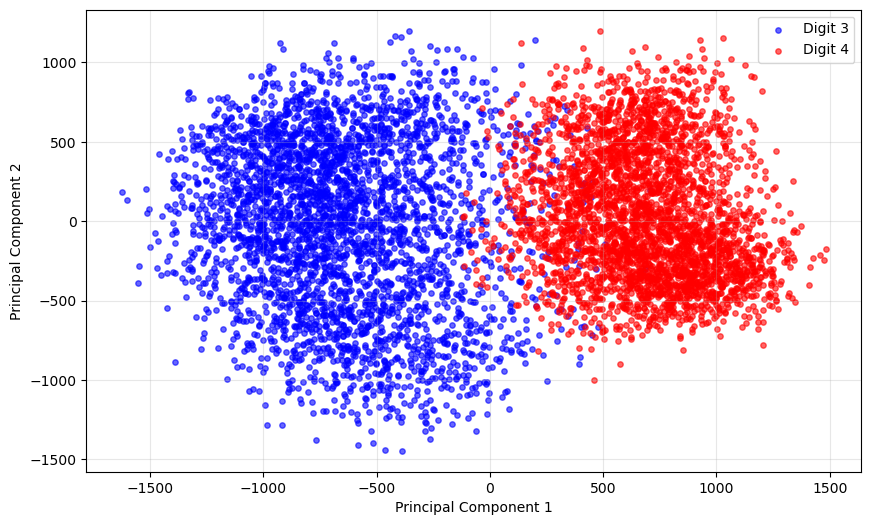

In [23]:
from sklearn.model_selection import train_test_split

display(data.describe())

random_state = 42
X_raw = data.drop('label', axis=1).values
y_raw = data['label'].values

mask = (y_raw == 3) | (y_raw == 4)

X_filtered = X_raw[mask]
y_filtered = y_raw[mask]

print(f"Filtered Dataset Shape: {X_filtered.shape}. Original shape:{X_raw.shape}")

#stratify used for ensuring that the split is balanced
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=random_state, stratify=y_filtered
)

# --- 4. Centering ---
# Crucial: We compute the mean ONLY on the training set to avoid data leakage.
mean_vec = np.mean(X_train, axis=0)

# Center the training data
X_c_train = X_train - mean_vec

# Center the test data using the TRAINING mean
X_c_test = X_test - mean_vec

# --- 5. Compute PCA via SVD ---
# We perform Singular Value Decomposition on the centered training data.
# numpy.linalg.svd returns u, s, vh (where vh is V transposed)
# full_matrices=False makes it faster by not computing the full U matrix
u, s, vh = np.linalg.svd(X_c_train, full_matrices=False)

# The rows of vh are the principal directions (eigenvectors).
# We take the first two rows (top 2 principal components).
# We transpose (.T) to get shape (d, 2) for matrix multiplication.
P = vh[:2, :].T

print(f"Projection Matrix P shape: {P.shape}")

# --- 6. Project Data ---
# Project X onto the 2D subspace defined by P.
# Formula: Z = X_centered @ P
Z_train = X_c_train @ P
Z_test = X_c_test @ P

print(f"Projected Train Shape: {Z_train.shape}")
print(f"Projected Test Shape:  {Z_test.shape}")

# --- 7. Visualization ---
# Let's verify the separation in 2D space
plt.figure(figsize=(10, 6))
classes = [3, 4]
colors = ['blue', 'red']

for digit, color in zip(classes, colors):
    # Select points belonging to the current digit
    subset = Z_train[y_train == digit]
    plt.scatter(subset[:, 0], subset[:, 1], 
                alpha=0.6, s=15, label=f"Digit {digit}", c=color)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 2: Fit a linear classifier


In [18]:
#to make the sigmoid work we have to map the labels: 3->0, 4->1
y_train_bin = (y_train == 4).astype(int)
y_test_bin = (y_test == 4).astype(int)

# Add bias term (column of 1s) to Z
N_train = Z_train.shape[0]
N_test = Z_test.shape[0]

Z_train_b = np.hstack((np.ones((N_train, 1)), Z_train))
Z_test_b = np.hstack((np.ones((N_test, 1)), Z_test))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Hyperparameters
lr = 0.01
epochs = 200
batch_size = 32
D = Z_train_b.shape[1] # Dimension is now 3 (Bias + PC1 + PC2)

# Initialize Theta
np.random.seed(42)
theta = np.zeros(D)

for epoch in range(epochs):
    # Shuffle
    indices = np.random.permutation(N_train)
    Z_shuff, y_shuff = Z_train_b[indices], y_train_bin[indices]
    
    for i in range(0, N_train, batch_size):
        Z_batch = Z_shuff[i:i+batch_size]
        y_batch = y_shuff[i:i+batch_size]
        
        # Forward
        preds = sigmoid(Z_batch @ theta)
        
        # Gradient: X.T * (preds - y) / N
        grad = Z_batch.T @ (preds - y_batch) / len(y_batch)
        
        # Update
        theta -= lr * grad

print(f"Training Complete. Learned Theta: {np.round(theta, 4)}")#[-11.6241   1.1067   0.183 ]


C:\Users\filip\AppData\Local\Temp\ipykernel_25500\547568358.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Training Complete. Learned Theta: [-11.6721   3.7126   0.2542]


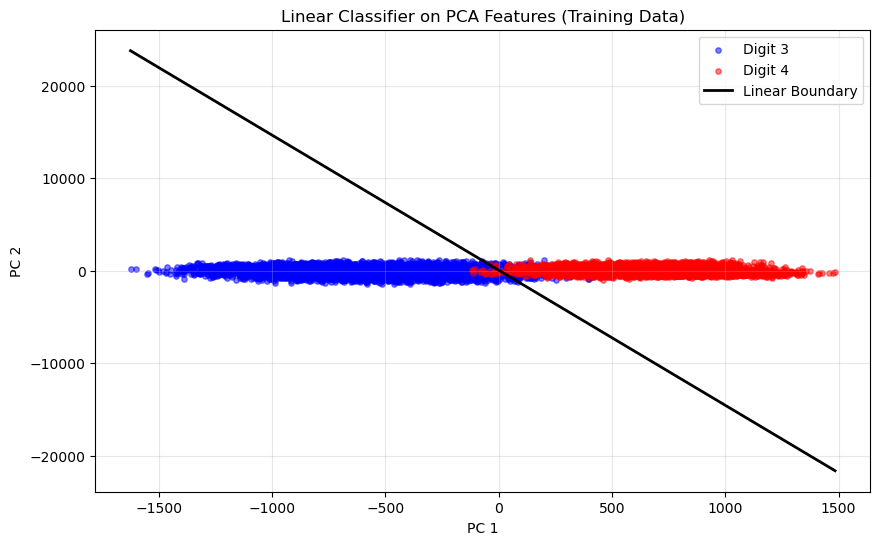

--- Test Set Evaluation ---
Accuracy:  0.9739
Precision: 0.9519 (Digit 4)
Recall:    0.9963 (Digit 4)
Confusion Matrix:
 [[829  41]
  [3  812]]


C:\Users\filip\AppData\Local\Temp\ipykernel_25500\547568358.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [19]:
# --- 1. Plotting the Decision Boundary ---
plt.figure(figsize=(10, 6))

# Scatter plot of Training Data
# We plot points classified as 3 (blue) and 4 (red)
plt.scatter(Z_train[y_train==3, 0], Z_train[y_train==3, 1], alpha=0.5, label='Digit 3', c='blue', s=15)
plt.scatter(Z_train[y_train==4, 0], Z_train[y_train==4, 1], alpha=0.5, label='Digit 4', c='red', s=15)

# Calculate Decision Boundary Line
# We define a range for z1 (PC1) covering the data spread
z1_vals = np.linspace(Z_train[:, 0].min(), Z_train[:, 0].max(), 100)
# Solve for z2
z2_vals = - (theta[0] + theta[1] * z1_vals) / theta[2]

plt.plot(z1_vals, z2_vals, 'k-', linewidth=2, label='Linear Boundary')

plt.title("Linear Classifier on PCA Features (Training Data)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 2. Evaluation on Test Set ---

# Predict on Test Data
probs_test = sigmoid(Z_test_b @ theta)
preds_test = (probs_test >= 0.5).astype(int)

# Metrics Calculation
tp = np.sum((preds_test == 1) & (y_test_bin == 1)) # Correctly predicted 4
tn = np.sum((preds_test == 0) & (y_test_bin == 0)) # Correctly predicted 3
fp = np.sum((preds_test == 1) & (y_test_bin == 0)) # Predicted 4, actually 3
fn = np.sum((preds_test == 0) & (y_test_bin == 1)) # Predicted 3, actually 4

accuracy = (tp + tn) / len(y_test_bin)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print("--- Test Set Evaluation ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (Digit 4)")
print(f"Recall:    {recall:.4f} (Digit 4)")
print(f"Confusion Matrix:\n [[{tn}  {fp}]\n  [{fn}  {tp}]]")

### Step 3

Centroid Digit 3 (PCA coords): [-641.    -32.75]
Centroid Digit 4 (PCA coords): [685.08  35.  ]

--- PCA-Centroid Classifier Results ---
Accuracy:  0.9733
Precision: 0.9519
Recall:    0.9951
Confusion Matrix:
 [[829  41]
  [4  811]]


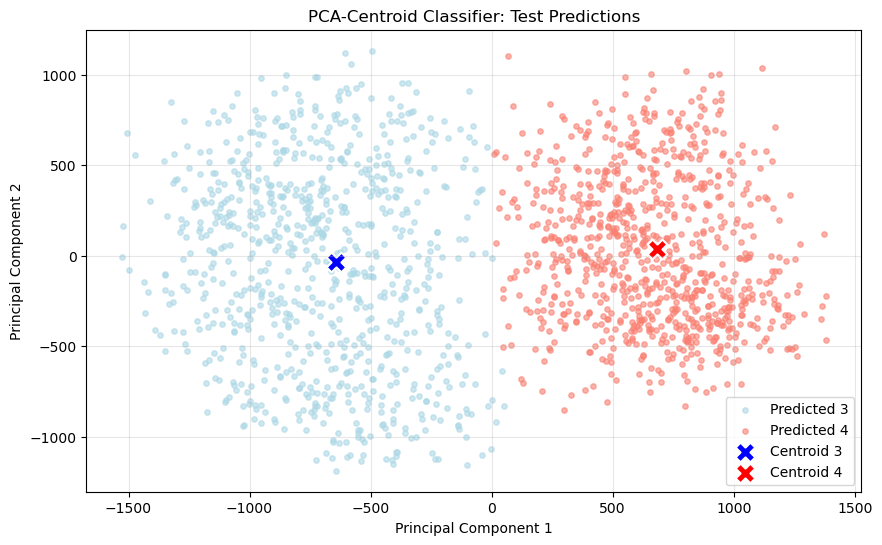

In [20]:
# --- 1. Compute Centroids ---

# We filter the projected training data (Z_train) by class label
# y_train_bin was defined in Step 2: 0 for "Digit 3", 1 for "Digit 4"
Z_3 = Z_train[y_train_bin == 0]
Z_4 = Z_train[y_train_bin == 1]

# Calculate the mean position (centroid) for each cluster
# axis=0 computes the mean across the rows (samples), resulting in a (2,) vector
mu_3 = np.mean(Z_3, axis=0)
mu_4 = np.mean(Z_4, axis=0)

print(f"Centroid Digit 3 (PCA coords): {np.round(mu_3, 2)}")
print(f"Centroid Digit 4 (PCA coords): {np.round(mu_4, 2)}")

# --- 2. Classification on Test Set ---

# We compute the Euclidean distance from every test point to each centroid.
# Z_test has shape (N_test, 2).
# mu_3 has shape (2,).
# Numpy broadcasting allows us to subtract the vector mu from every row of Z_test.

# Distance to Centroid 3: || z - mu_3 ||
dist_3 = np.linalg.norm(Z_test - mu_3, axis=1)

# Distance to Centroid 4: || z - mu_4 ||
dist_4 = np.linalg.norm(Z_test - mu_4, axis=1)

# Prediction Rule:
# If dist_4 < dist_3, predict 1 (Digit 4). Otherwise, predict 0 (Digit 3).
preds_centroid = (dist_4 < dist_3).astype(int)

# --- 3. Evaluation ---

# We compare our geometric predictions against the true binary labels
tp = np.sum((preds_centroid == 1) & (y_test_bin == 1))
tn = np.sum((preds_centroid == 0) & (y_test_bin == 0))
fp = np.sum((preds_centroid == 1) & (y_test_bin == 0))
fn = np.sum((preds_centroid == 0) & (y_test_bin == 1))

# Standard Metrics
acc_cent = (tp + tn) / len(y_test_bin)
prec_cent = tp / (tp + fp) if (tp + fp) > 0 else 0.0
rec_cent = tp / (tp + fn) if (tp + fn) > 0 else 0.0

print("\n--- PCA-Centroid Classifier Results ---")
print(f"Accuracy:  {acc_cent:.4f}")
print(f"Precision: {prec_cent:.4f}")
print(f"Recall:    {rec_cent:.4f}")
print(f"Confusion Matrix:\n [[{tn}  {fp}]\n  [{fn}  {tp}]]")

# --- 4. Visualization ---
plt.figure(figsize=(10, 6))

# Plot the Test points, colored by their PREDICTED class
# This visualizes the decision regions created by the centroids
plt.scatter(Z_test[preds_centroid==0, 0], Z_test[preds_centroid==0, 1], 
            c='lightblue', alpha=0.6, s=15, label='Predicted 3')
plt.scatter(Z_test[preds_centroid==1, 0], Z_test[preds_centroid==1, 1], 
            c='salmon', alpha=0.6, s=15, label='Predicted 4')

# Plot the actual Centroids
plt.scatter(mu_3[0], mu_3[1], c='blue', s=200, marker='X', edgecolors='white', linewidth=1.5, label='Centroid 3')
plt.scatter(mu_4[0], mu_4[1], c='red', s=200, marker='X', edgecolors='white', linewidth=1.5, label='Centroid 4')

plt.title("PCA-Centroid Classifier: Test Predictions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 4

C:\Users\filip\AppData\Local\Temp\ipykernel_25500\547568358.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


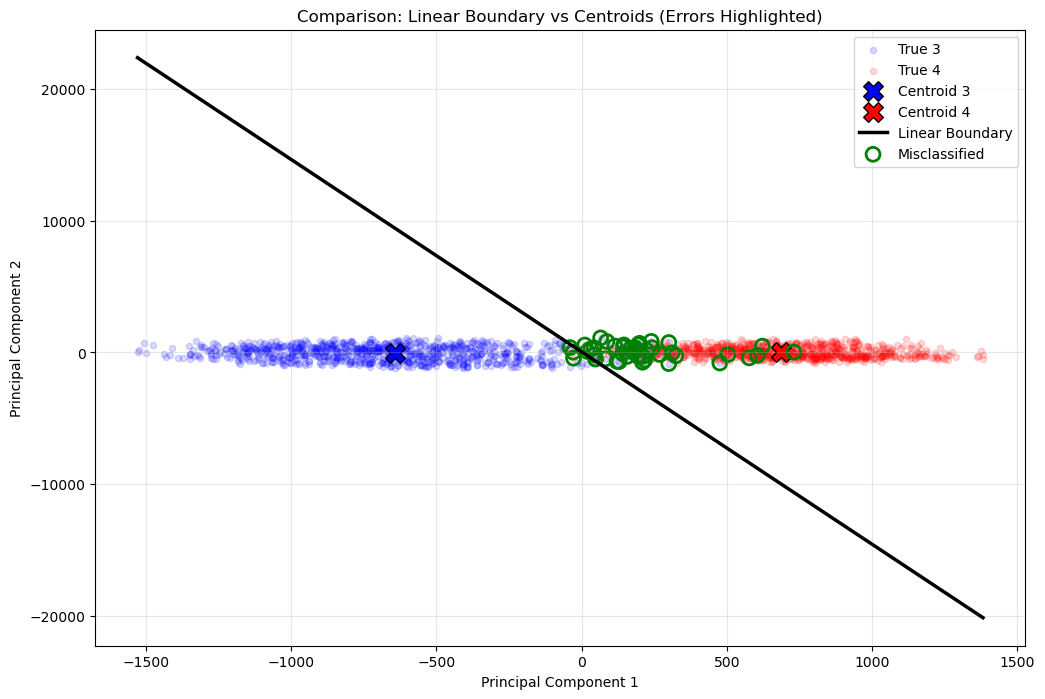

Linear Model Accuracy:   0.9739
Centroid Model Accuracy: 0.9733
Total Misclassified Points: 44 out of 1685


In [21]:
# --- 1. Identify Misclassified Points (Linear Model) ---
# We use the Theta learned in Step 2 to get predictions
probs_linear = sigmoid(Z_test_b @ theta)
preds_linear = (probs_linear >= 0.5).astype(int)

# Boolean mask for errors: True where Prediction != Truth
error_mask = (preds_linear != y_test_bin)
Z_errors = Z_test[error_mask]

# --- 2. Combined Visualization ---
plt.figure(figsize=(12, 8))

# A. Plot True Classes (dimmed)
plt.scatter(Z_test[y_test_bin==0, 0], Z_test[y_test_bin==0, 1], 
            c='blue', alpha=0.15, s=20, label='True 3')
plt.scatter(Z_test[y_test_bin==1, 0], Z_test[y_test_bin==1, 1], 
            c='red', alpha=0.15, s=20, label='True 4')

# B. Plot Centroids
plt.scatter(mu_3[0], mu_3[1], c='blue', s=200, marker='X', edgecolors='black', label='Centroid 3')
plt.scatter(mu_4[0], mu_4[1], c='red', s=200, marker='X', edgecolors='black', label='Centroid 4')

# C. Plot Linear Decision Boundary
# We calculate the line z2 = -(theta0 + theta1*z1) / theta2
x_range = np.linspace(Z_test[:, 0].min(), Z_test[:, 0].max(), 100)
y_range = - (theta[0] + theta[1] * x_range) / theta[2]
plt.plot(x_range, y_range, 'k-', linewidth=2.5, label='Linear Boundary')

# D. Highlight Errors
plt.scatter(Z_errors[:, 0], Z_errors[:, 1], 
            facecolors='none', edgecolors='green', s=100, linewidth=2, label='Misclassified')

plt.title("Comparison: Linear Boundary vs Centroids (Errors Highlighted)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. Quantitative Comparison ---
print(f"Linear Model Accuracy:   {accuracy:.4f}")
print(f"Centroid Model Accuracy: {acc_cent:.4f}")
print(f"Total Misclassified Points: {len(Z_errors)} out of {len(y_test)}")


### Final Discussion

1. Linear vs. Centroid Performance

You will observe that the accuracies are very close (often within 1-2%).

- This happens because PCA tends to produce "blob-like" Gaussian clusters.
- When two clusters are spherical and separated, the optimal linear boundary is geometrically very close to the perpendicular bisector used by the Centroid Classifier.

2. Effect of Changing Digits (Class Similarity)

The exercise asks to consider pairs like (1,7) and (5,8). While we implemented the code for (3,4), we can predict the behavior based on PCA properties:

- **Distinct Pairs (e.g., 0 vs 1, or 1 vs 7 in US handwriting):**

    - **Cluster Shape:** The clusters in PCA space will be far apart with almost no overlap.
    - **Performance:** Both classifiers will achieve near 100% accuracy. The decision boundary will pass through empty space.
- **Similar Pairs (e.g., 5 vs 8, or 3 vs 5):**

    - **Cluster Shape:** These digits share structural similarities (curves, loops). In PCA space, their clusters will overlap significantly.
    - **Centroid Separation:** The distance $\|\mu\_5 - \mu\_8\|$ will be small compared to the spread (variance) of the data.
    - **Performance:** Both classifiers will struggle. You will see a "dense cloud" of green misclassified points in the middle where the 5s and 8s mix. The linear boundary will try to cut through the middle of this mix, but errors are unavoidable in 2D.

Conclusion:

This demonstrates that PCA is not just for visualization; it effectively compresses the discriminative information of the images. If digits look different to the human eye, they generally map to distinct regions in the PCA plane, making simple linear or geometric classifiers surprisingly effective.